In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Walmart_store_sales.csv')
df=data.dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
df.info()
df.head()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Weekly_Sales  143 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


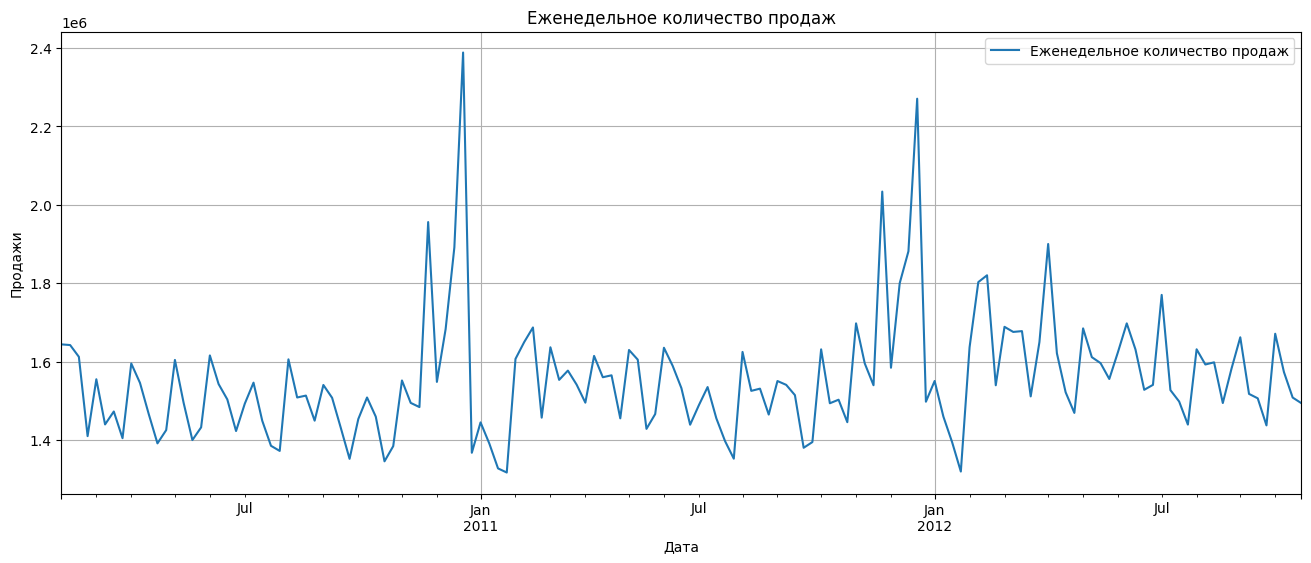

In [3]:
df['2010-02-05':'2012-10-26'].plot(figsize=(16,6), 
                                       grid=True, 
                                       xlabel='Дата',
                                       ylabel='Продажи',
                                       title='Еженедельное количество продаж')
plt.legend(['Еженедельное количество продаж'])
plt.show()
#видим график с выраженной сезонностью

In [4]:
adf_test = adfuller(df.values)

if adf_test[1] < 0.05:
    print('p-value = ', adf_test[1],
          '\nРяд стационарный')
else:
    print('p-value = ', adf_test[1],
          '\nРяд нестационарный')

#данный ряд считается стационарным, значит дифферинцировать ему нам не придется

p-value =  1.3877788330759535e-05 
Ряд стационарный


<Figure size 1600x600 with 0 Axes>

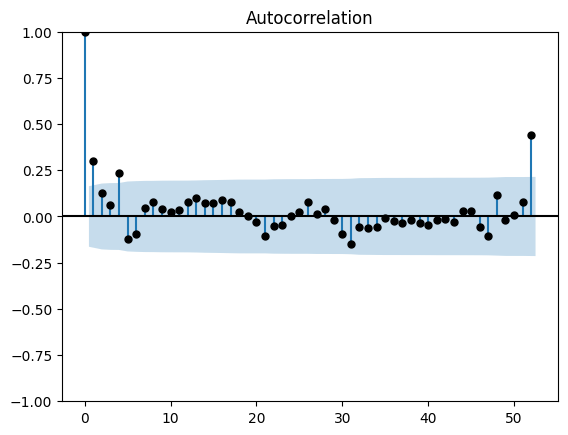

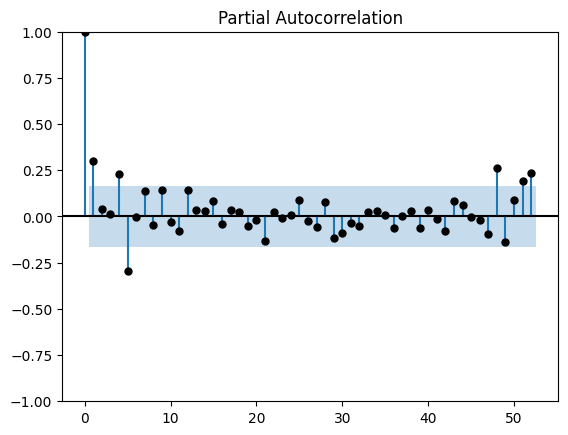

In [5]:
plt.figure(figsize=(16, 6))
plot_acf(df.values, lags=52, color='black')
plot_pacf(df.values, lags=52,  color='black')
plt.show()

Нам нужно подобрать нужные параметры для модели Sarima,так как модель Arima будет скорее всего работать неточно(у нас есть сезонность). Из графика Partal Autocorrelation мы можем выявить два параметра. Параметр p(наиболее отличный от нуля lag) будет равен 5. Параметр P решил взять 5, так как мы видим на периодечских лагах хоть и небольшие, но всплески(для сезонных параметров даже это может быть важно). Из графика Autocorellation можно выявить параметры q и Q. Парамер q взял 4, так как после 4-ого лага все данные успокоились и находятся в коридоре допустимых значений. Параметр Q возьму 1, так как на 52 лаге у нас есть всплеск, именно с таким периодом мы и будем строить нашу модель(m=52). Параметр d поставим 0, мы ничего не дифференцировали изначально. Параметр D ставим 1, так как именно после 1-ой дифференсации сезонность полностью пропадет.

In [6]:
x_train, x_test = train_test_split(df, 
                                   test_size=.04, 
                                   shuffle=False) 
# решил предсказывать только 4 шага( первое, точность более точная, ошибка не успеет скопиться, второе,загрузка в разы быстрее)

In [7]:
model_arima = ARIMA(x_train.values, order=(5, 0, 4))
model_arima_fit = model_arima.fit()

In [8]:
start = len(x_train)
end = len(x_train) + len(x_test) -1

In [9]:
predictions = model_arima_fit.predict(start, end)
predictions = pd.DataFrame({'pred': predictions}, index=x_test.index)

In [10]:
def plot_prediction(df, test, pred):
    
    plt.figure(figsize=(16, 6))

    plt.plot(df, color = 'black')
    plt.plot(test, color = 'green')
    plt.plot(pred, color = 'red')
    
    plt.title('Обучающая выборка и прогноз')
    plt.legend(['Обучающая выборка', 'Тестовая выборка', 'Прогноз'])

    plt.grid()
    plt.show()

In [11]:
df_model = pd.DataFrame({'model_name': [],'R2': [], 'MAE': []})
    
def model_char(test, pred, df, model_name):
    mae = mean_absolute_error(x_test, predictions)
    r2 = r2_score(x_test, predictions)
    df_model.loc[len(df_model.index )] = [model_name, r2, mae]
    return df_model

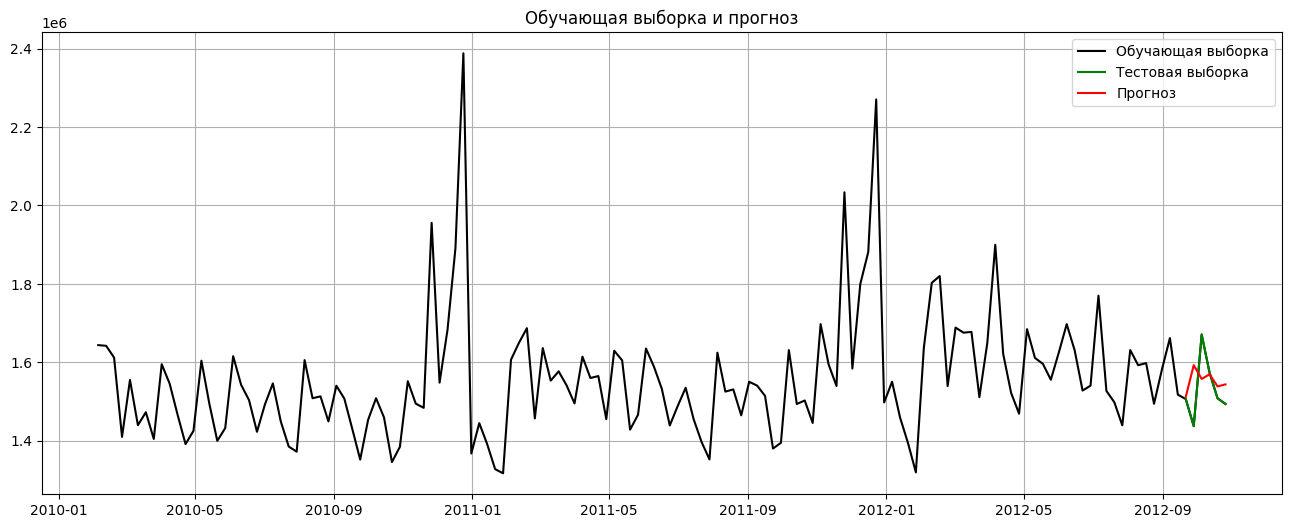

In [14]:
plot_prediction(df, x_test, predictions)

In [15]:
model_char(x_test, predictions, df_model, 'ARIMA')

,model_name,R2,MAE
0,ARIMA,-0.238751,59775.266756


Модель ARIMA мягко говоря плохо предсказала, это произошло из-за того, что мы совсем не учитываем сезнность, а по графику временного ряда четко видна данная компонента.

In [16]:
model_sarimax = SARIMAX(x_train,
                order = (5, 0, 4),
                seasonal_order = (5, 1, 1, 52))

model_sarimax_fit = model_sarimax.fit()

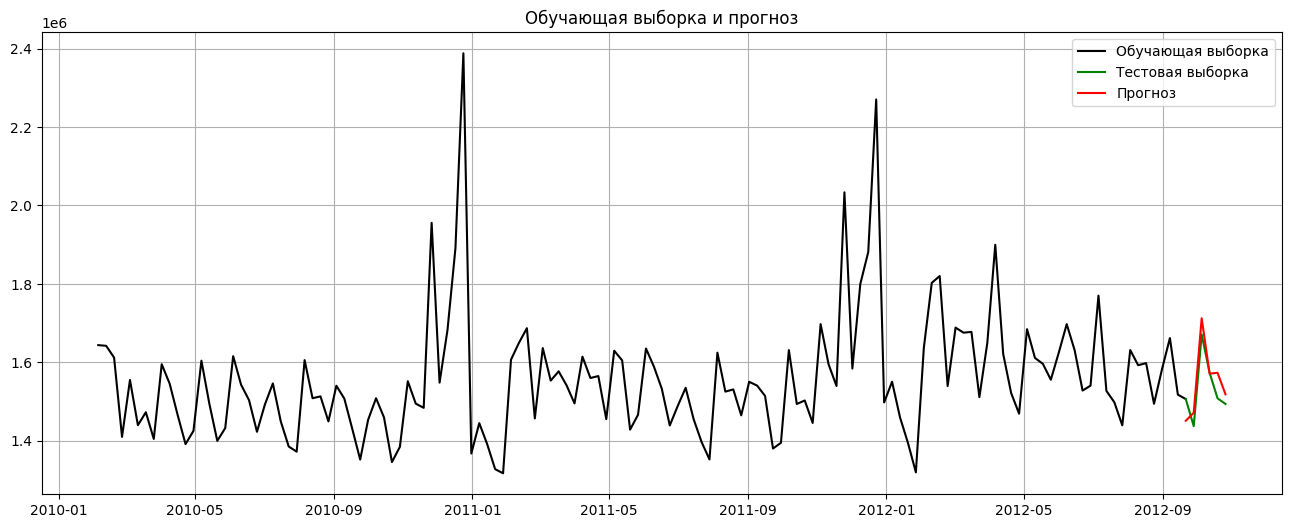

In [17]:
predictions = model_sarimax_fit.predict(start, end)
plot_prediction(df[:len(x_train)+1], x_test, predictions)

In [19]:
model_char(x_test, predictions, df_model, 'SARIMAX')

,model_name,R2,MAE
0,ARIMA,-0.238751,59775.266756
1,SARIMAX,0.669612,37143.198270
2,SARIMAX,0.669612,37143.198270


Модель Sarima намного лучше справляется с задачами, мы выбрали подходящие параметры сезонности и теперь наш прогноз в разы точнее-66%

In [20]:
auto_model = auto_arima(x_train.values, 
                        start_p=0, 
                        start_q=0, 
                        max_p=10, 
                        max_q=10,
                        d=0,
                        start_P=0, 
                        start_Q=0, 
                        max_P=8, 
                        max_D=1, 
                        max_Q=8, 
                        max_order=20,
                        m=52,
                        seasonal=False)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  137
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1827.631
Date:                Mon, 06 Oct 2025   AIC                           3661.261
Time:                        18:33:57   BIC                           3670.021
Sample:                             0   HQIC                          3664.821
                                - 137                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.08e+06   8.27e+04     13.055      0.000    9.18e+05    1.24e+06
ar.L1          0.3060      0.048      6.422      0.000       0.213       0.399
sigma2      2.274e+10      0.394   5.77e+10      0.000    2.27e+10    2.27e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               241.19
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             1.63
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.47e+26. Standard errors may be unstable.
"""

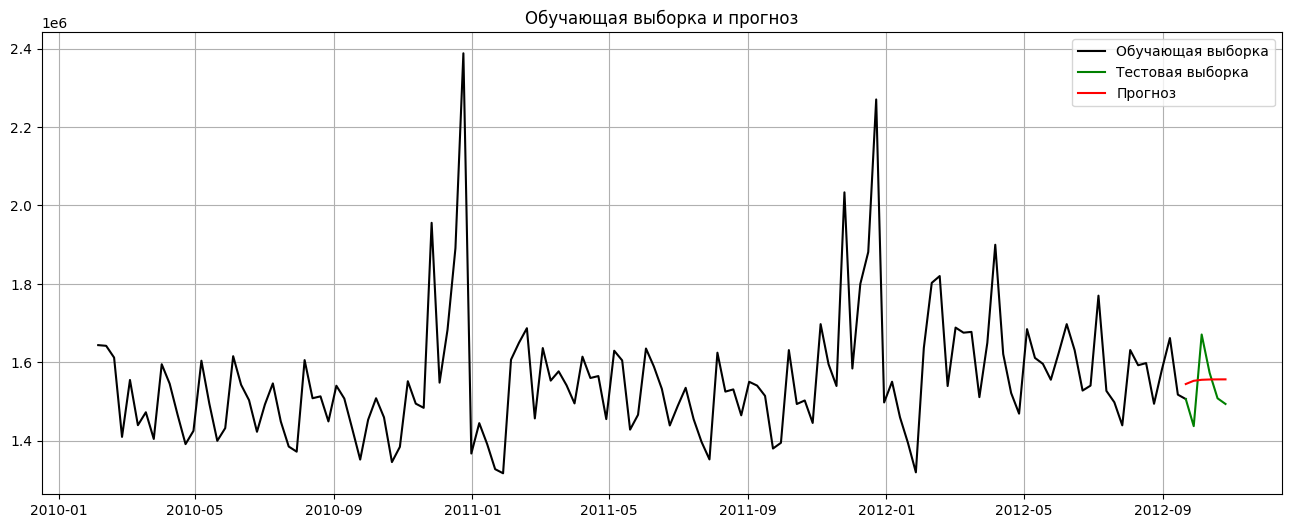

In [21]:
auto_model.fit(x_train)

predictions = auto_model.predict(n_periods=len(x_test))
predictions = pd.DataFrame({'pred': predictions}, index=x_test.index)
plot_prediction(df[:len(x_train)+1], x_test, predictions)

In [ ]:
Модель autoarima не справилась с задачей, дала плохой результат.

In [ ]:
# определим оптимальные параметры  p, d, q, P, D, Q перебором

# зададим диапазон значений для p, d, q, P, D, Q и m
p_values = range(0, 6)  
d_values = [0]         
q_values = range(0, 6)  
P_values = range(0, 6)  
D_values = range(0, 1)  
Q_values = range(0, 6)  
m_values = [52]         

# создадим все возможные комбинации параметров SARIMAX
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))

# зададим нулевые начальные значения
best_r2 = 0  
best_params = None

# выполним поиск по сетке
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = SARIMAX(x_train.values, 
                        order=order, 
                        seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        predictions = model_fit.predict(start, end)
        r2 = r2_score(x_test, predictions)
        
        # проверим сходимость модели
        if not math.isinf(model_fit.zvalues.mean()):
            print(order, seasonal_order, r2)
        
            if r2 > best_r2:
                best_r2 = r2
                best_params = params
                
        else:
            print(order, seasonal_order, 'нет сходимости')

    except:
        continue

print("Лучшие параметры:", best_params)
print("Лучший коэффициент R2:", best_r2)

(0, 0, 0) (0, 0, 0, 52) -430.7042333470466
(0, 0, 0) (0, 0, 1, 52) -190.75012404319054
(0, 0, 0) (0, 0, 2, 52) -106.99147805098322
(0, 0, 0) (0, 0, 3, 52) -68.32617625715054
(0, 0, 0) (0, 0, 4, 52) -40.48630133221793
(0, 0, 0) (0, 0, 5, 52) -17.211767872895923
(0, 0, 0) (1, 0, 0, 52) 0.11545665373014347
(0, 0, 0) (1, 0, 1, 52) 0.012950149400997368
(0, 0, 0) (1, 0, 2, 52) 0.014664294231071073
(0, 0, 0) (1, 0, 3, 52) 0.016251399618309237
(0, 0, 0) (1, 0, 4, 52) 0.017794511992171524
(0, 0, 0) (1, 0, 5, 52) 0.019144423709278158
(0, 0, 0) (2, 0, 0, 52) 0.15664793233644891
(0, 0, 0) (2, 0, 1, 52) -0.012571986665341317
(0, 0, 0) (2, 0, 2, 52) 0.01460833015743157
(0, 0, 0) (2, 0, 3, 52) 0.016273044565851325
(0, 0, 0) (2, 0, 4, 52) 0.017708788037278267
(0, 0, 0) (2, 0, 5, 52) 0.019249493259278605
(0, 0, 0) (3, 0, 0, 52) 0.011713674168135846
(0, 0, 0) (3, 0, 1, 52) 0.013263719430090637
(0, 0, 0) (3, 0, 2, 52) 0.01478319823041574
(0, 0, 0) (3, 0, 3, 52) 0.01621973597375803
(0, 0, 0) (3, 0, 4, 52)

In [12]:
model_sarimax = SARIMAX(x_train,
                order = (1, 0, 4),
                seasonal_order = (5, 0, 4, 52))

model_sarimax_fit = model_sarimax.fit()

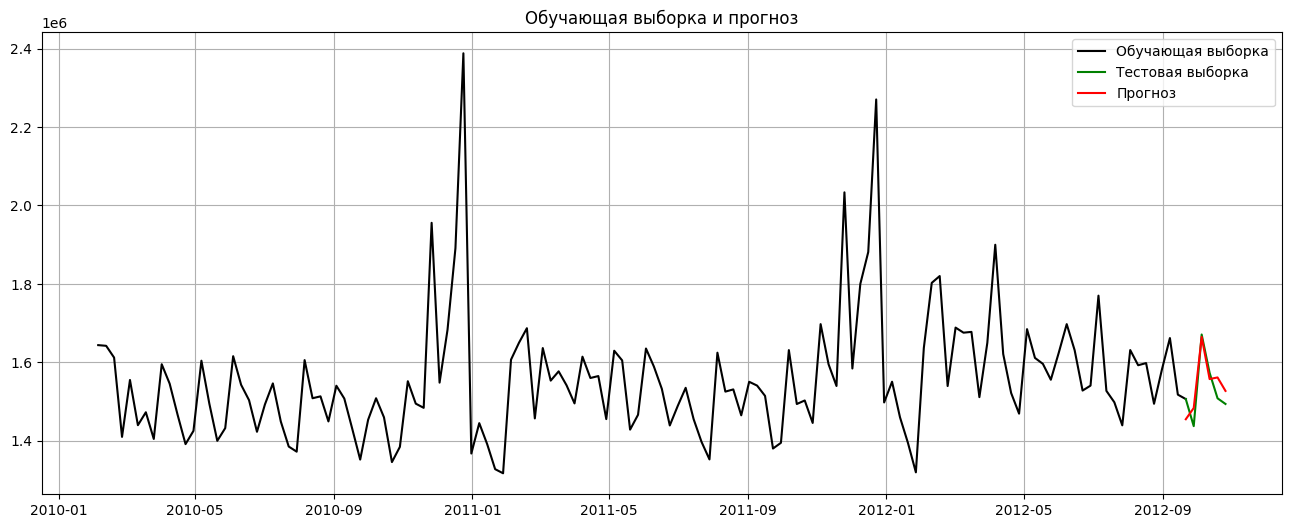

In [13]:
predictions = model_sarimax_fit.predict(start, end)
plot_prediction(df[:len(x_train)+1], x_test, predictions)

In [14]:
model_char(x_test, predictions, df_model, 'SARIMAX')

,model_name,R2,MAE
0,SARIMAX,0.723958,34377.631715


Обычный подбор парамаетров методом перебора наверное самый эффективный способ найти лучшую модель, однако невероятно затратная,за целый день у меня обработалось около 20% возможных данных. Я взял лучший результат из всех, которые смог подсчитать, однако думаю, что есть и лучше.

# Вывод:
Модель Arima работает неплохо ровно до момента, пока не появляются сезонные компоненты, в теории данные можно преобразовать специально для улучшения данной модели, но работать это будет буквально для 3-4 шагов(и то не всегда). Для данного датасета